In [1]:
%cd ..

f:\DS Lab\OT\ot-kpgg-fc


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [3]:
#@title Dimensionality
n_anchors = 4
n_keypoints = 4
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=3*n_anchors, alpha=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, 5-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = Dimensionality(model=models, log_dir="logs")
results = experiment(noise_level=0.5, max_projected_dim=100, freq_projected_dim=5, hyperplane_dim=5,
                     n_components=k, cluster_samples=100, n_keypoints=n_keypoints, 
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                     )

Threshold reached at iteration 13
Dimension: 5, Accuracy: {'KeypointFOT': 0.44, 'FOT': 0.155, 'LOT': 0.2175, 'OT': 0.2225}, Runtime: {'KeypointFOT': 14.03775691986084, 'FOT': 29.410093069076538, 'LOT': 0.34552717208862305, 'OT': 0.073486328125}
Threshold reached at iteration 38
Dimension: 10, Accuracy: {'KeypointFOT': 0.41, 'FOT': 0.1575, 'LOT': 0.22, 'OT': 0.2175}, Runtime: {'KeypointFOT': 39.20543837547302, 'FOT': 27.60794758796692, 'LOT': 0.34013819694519043, 'OT': 0.05968928337097168}
Threshold reached at iteration 12
Dimension: 15, Accuracy: {'KeypointFOT': 0.4625, 'FOT': 0.235, 'LOT': 0.2425, 'OT': 0.2075}, Runtime: {'KeypointFOT': 9.825231790542603, 'FOT': 14.458978414535522, 'LOT': 0.359027624130249, 'OT': 0.06020998954772949}
Threshold reached at iteration 11
Dimension: 20, Accuracy: {'KeypointFOT': 0.44, 'FOT': 0.15, 'LOT': 0.2225, 'OT': 0.18}, Runtime: {'KeypointFOT': 8.739977598190308, 'FOT': 12.236559867858887, 'LOT': 0.4196624755859375, 'OT': 0.07133340835571289}


Noise ratio: 0.0, Accuracy: {'KeypointFOT': 0.1925, 'FOT': 0.01, 'LOT': 0.2125, 'OT': 0.1925}, Runtime: {'KeypointFOT': 0.5612430572509766, 'FOT': 7.4529149532318115, 'LOT': 2.0246217250823975, 'OT': 0.11006379127502441}
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 0.19, 'FOT': 0.0175, 'LOT': 0.215, 'OT': 0.2025}, Runtime: {'KeypointFOT': 0.6684019565582275, 'FOT': 13.175093412399292, 'LOT': 1.8042807579040527, 'OT': 0.08957791328430176}
Noise ratio: 0.2, Accuracy: {'KeypointFOT': 0.1975, 'FOT': 0.0175, 'LOT': 0.2275, 'OT': 0.1925}, Runtime: {'KeypointFOT': 0.6049079895019531, 'FOT': 4.147220611572266, 'LOT': 1.846545934677124, 'OT': 0.08220076560974121}
Noise ratio: 0.30000000000000004, Accuracy: {'KeypointFOT': 0.1825, 'FOT': 0.03, 'LOT': 0.1975, 'OT': 0.205}, Runtime: {'KeypointFOT': 0.6149537563323975, 'FOT': 5.931276798248291, 'LOT': 1.7227962017059326, 'OT': 0.08134269714355469}
Noise ratio: 0.4, Accuracy: {'KeypointFOT': 0.175, 'FOT': 0.025, 'LOT': 0.2125, 'OT': 0.19}, Runtime: {

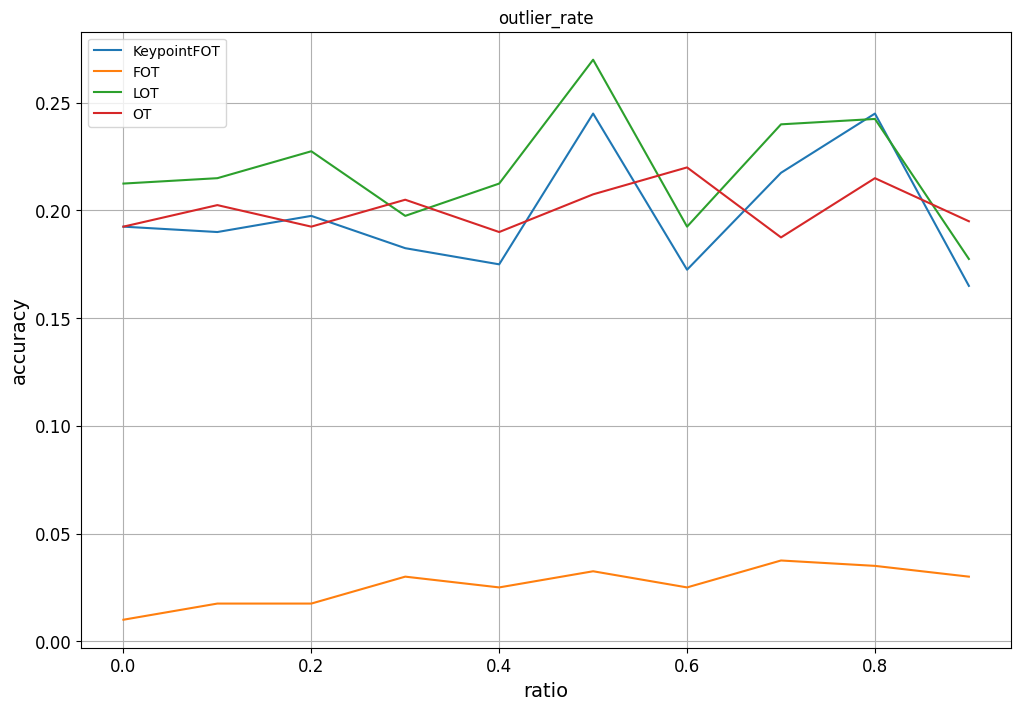

In [ ]:

#@title Outlier rate
n_anchors = 4
n_keypoints = 4
d = 30
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, alpha=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, 
                     cluster_samples=100, n_keypoints=n_keypoints, n_components=k,
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                    )

Number of source components: 2, Accuracy: {'KeypointFOT': 0.0, 'FOT': 0.065, 'LOT': 0.0, 'OT': 0.11}, Runtime: {'KeypointFOT': 0.7268524169921875, 'FOT': 12.700510740280151, 'LOT': 0.5989601612091064, 'OT': 0.09619402885437012}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.0, 'FOT': 0.08, 'LOT': 0.0, 'OT': 0.13333333333333333}, Runtime: {'KeypointFOT': 0.6626732349395752, 'FOT': 7.030931234359741, 'LOT': 0.802295446395874, 'OT': 0.16245627403259277}
Number of source components: 4, Accuracy: {'KeypointFOT': 0.005, 'FOT': 0.08, 'LOT': 0.005, 'OT': 0.1675}, Runtime: {'KeypointFOT': 0.8059093952178955, 'FOT': 4.33411717414856, 'LOT': 1.0285911560058594, 'OT': 0.24631381034851074}
Number of source components: 5, Accuracy: {'KeypointFOT': 0.048, 'FOT': 0.222, 'LOT': 0.048, 'OT': 0.186}, Runtime: {'KeypointFOT': 1.4194529056549072, 'FOT': 5.011182546615601, 'LOT': 1.2297186851501465, 'OT': 0.2225053310394287}
Number of source components: 6, Accuracy: {'KeypointFOT': 0.26, 'FOT':

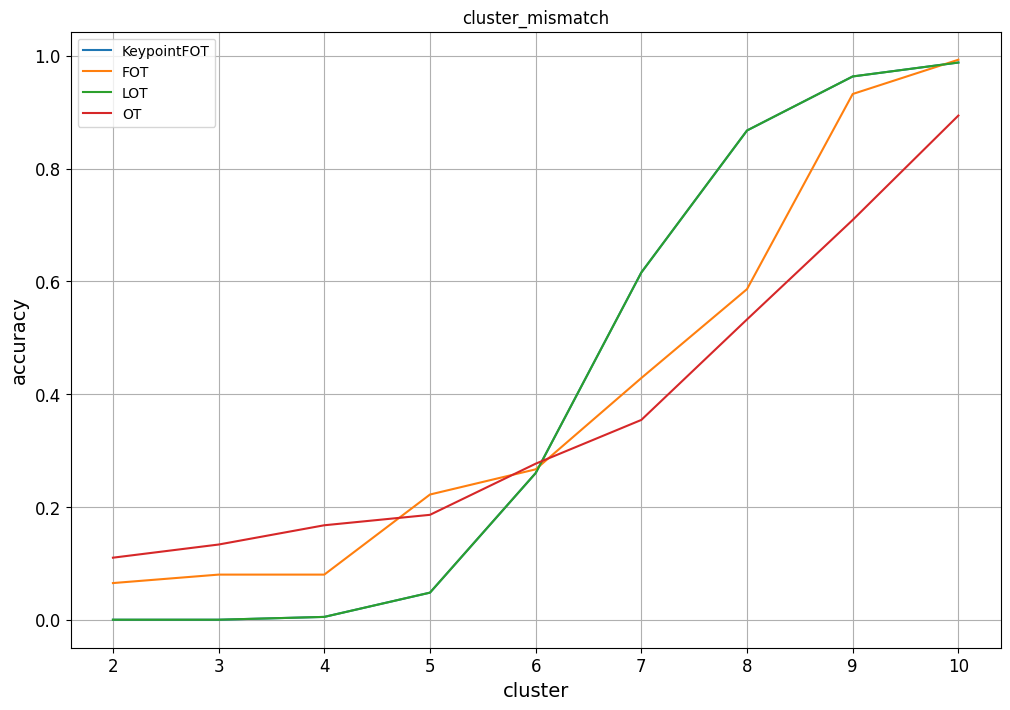

{'KeypointFOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.0,
   0.0,
   0.005,
   0.048,
   0.26,
   0.6157142857142858,
   0.8675,
   0.9633333333333334,
   0.988],
  'runtime': [0.7268524169921875,
   0.6626732349395752,
   0.8059093952178955,
   1.4194529056549072,
   1.219102144241333,
   1.3729181289672852,
   1.7637360095977783,
   1.9407241344451904,
   2.605504035949707]},
 'FOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.065,
   0.08,
   0.08,
   0.222,
   0.26666666666666666,
   0.42857142857142855,
   0.58625,
   0.9322222222222222,
   0.993],
  'runtime': [12.700510740280151,
   7.030931234359741,
   4.33411717414856,
   5.011182546615601,
   4.672614097595215,
   5.378818035125732,
   5.414768695831299,
   5.718347787857056,
   6.678424835205078]},
 'LOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.0,
   0.0,
   0.005,
   0.048,
   0.26,
   0.6157142857142858,
   0.8675,
   0.9633333333333334,
   0.988],
  'runtime': [0.598

In [ ]:

#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, alpha=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = ClusterMismatch(model=models, log_dir="logs")
experiment(min_source_components=2, freq_components=1, target_components=k, 
           hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints,
           src_properties={"means": mean_s, "cov_scale": 0.1},
           trg_properties={"means": mean_t, "cov_scale": 0.1},
           )